### Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer:  начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import random
from tqdm import tqdm


Bad key "text.kerning_factor" on line 4 in
C:\Users\asyas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def choose_move(Q, state, empty_spaces, eps):
    number_of_moves = len(empty_spaces)
    move = np.random.randint(number_of_moves)
    if state in Q:  
        if random.random() > eps:
            move = np.argmax(Q[state])
    else:
        Q[state] = np.zeros(number_of_moves)
    return move, empty_spaces[move]

In [5]:
def Q_learning(env, pi_crosses, pi_noughts, alpha, epsilon, gamma):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    crosses_state,  crosses_action = None, None
    noughts_state, noughts_action = None, None
    while not done:
        if turn == 1:  # крестики
            move, move_aсtion = choose_move(pi_crosses, s, empty_spaces, eps=epsilon)
            state_new, reward, done, _ = env.step(move_aсtion)
            if reward == 1:
                pi_crosses[s][move] = 1
            if noughts_state: 
                pi_noughts[noughts_state][noughts_action] += alpha * \
                (- 1 * reward + gamma * np.max(pi_noughts.get(state_new[0], 0)) \
                 -  pi_noughts[noughts_state][noughts_action])
            crosses_state, crosses_action = s, move
            
        elif turn == -1:  # нолики
            move, move_aсtion = choose_move(pi_noughts, s, empty_spaces, eps=epsilon)  
            state_new, reward, done, _ = env.step(move_aсtion)
            if reward == -1:
                pi_noughts[s][move] = 1
            if crosses_state:
                pi_crosses[crosses_state][crosses_action] += alpha * \
                (reward + gamma * np.max(pi_crosses.get(state_new[0], 0)) \
                 - pi_crosses[crosses_state][crosses_action])
            noughts_state, noughts_action = s, move
            
        s, empty_spaces, turn = state_new

In [6]:
def play_game(env, pi_crosses, pi_noughts, game_type):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    while not done:
        Q = pi_crosses if game_type == 1 else pi_noughts
        eps = 0 if game_type == turn else 1
        move, move_aсtion = choose_move(Q, s, empty_spaces, eps=eps)
        state, reward, done, _ = env.step(move_aсtion)
        s, empty_spaces, turn = state
    return reward

In [7]:
def plot_stats(indicies, wins, title):
    plt.figure(figsize=(12, 8))
    plt.plot(indicies, wins, linewidth=1.5)
    plt.xlim(left=1)
    plt.xlabel("Количество эпизодов")
    plt.ylabel("Процент побед")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [19]:
def learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count,
             run_experiment_every, experiment_games_count):
    
    pi_crosses, pi_noughts = dict(), dict()
    indicies = []
    noughts_stat, crosses_stat = [], []

    for i in tqdm(range(q_learning_episodes_count)):
        Q_learning(env, pi_crosses, pi_noughts, alpha=0.015, epsilon=0.3, gamma=1.0)
        if i % run_experiment_every == 0: 
            current_noughts_stat, current_crosses_stat = [], []
            for _ in range(experiment_games_count):
                current_noughts_stat.append(play_game(env, pi_crosses, pi_noughts, game_type=-1))
                current_crosses_stat.append(play_game(env, pi_crosses, pi_noughts, game_type=1))
            noughts_stat.append(current_noughts_stat.count(-1) / experiment_games_count)
            crosses_stat.append(current_crosses_stat.count(1) / experiment_games_count)           
            indicies.append(i)

    plot_stats(indicies, crosses_stat, f"Крестики против случайной стратегии {env_name}")
    plot_stats(indicies, noughts_stat, f"Нолики против случайной стратегии  {env_name}")

In [10]:
alpha = 0.02
epsilon = 0.3
gamma = 0.9
experiment_games_count = 1_000
run_experiment_every = 5_000
q_learning_episodes_count = 200_000

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [06:08<00:00, 542.79it/s]


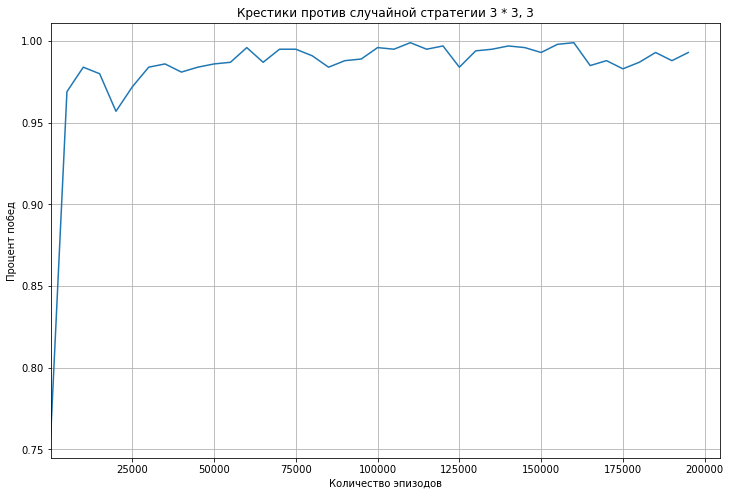

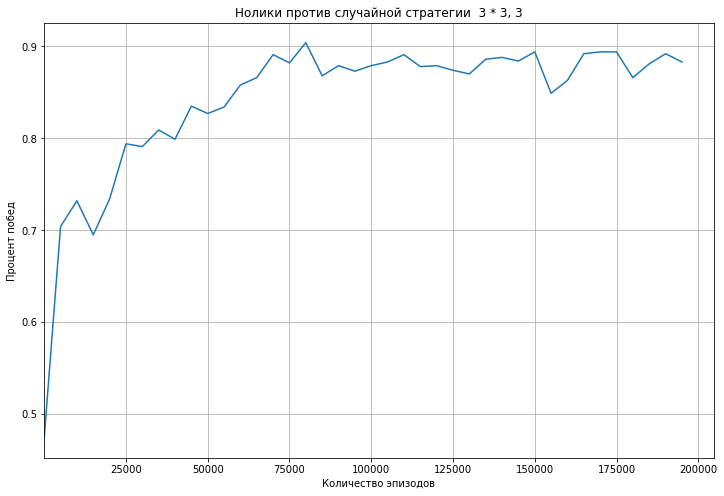

In [11]:
env = TicTacToe(3, 3, 3)
env_name = "3 * 3, 3"
learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count, run_experiment_every, experiment_games_count)

In [20]:
alpha = 0.015
epsilon = 0.3
gamma = 1
experiment_games_count = 1_000
run_experiment_every = 5_000
q_learning_episodes_count = 300_000

100%|█████████████████████████████████████████████████████████████████████████| 300000/300000 [21:54<00:00, 228.26it/s]


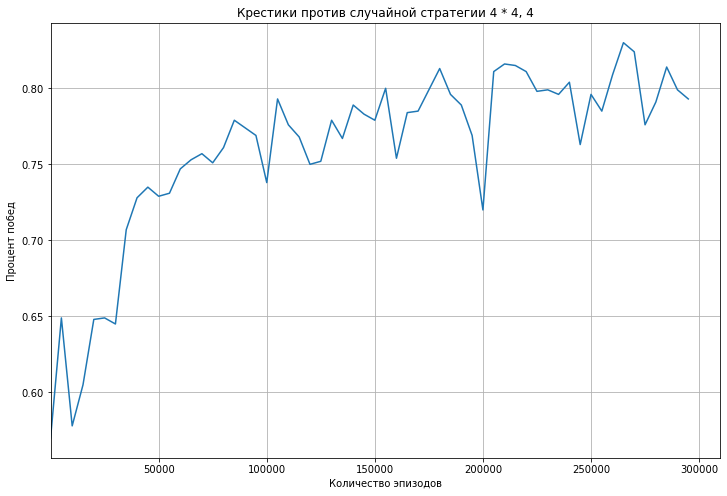

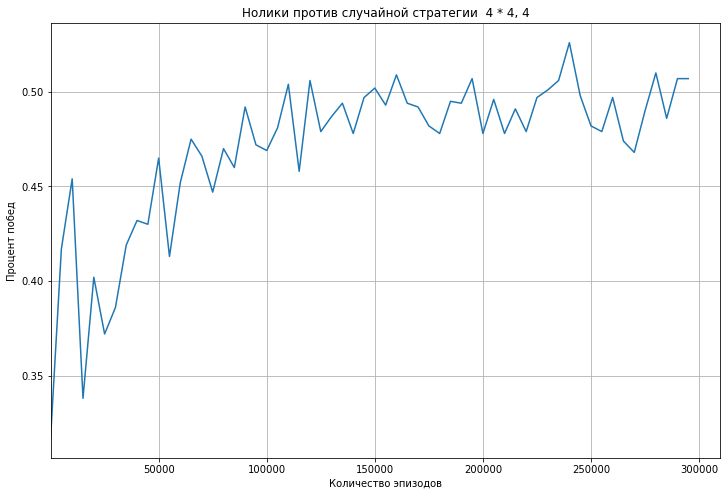

In [21]:
env = TicTacToe(4, 4, 4)
env_name = "4 * 4, 4"
learning(env, env_name, alpha, epsilon, gamma, q_learning_episodes_count, run_experiment_every, experiment_games_count)

P.s. к сожалению довести до ума DQN времени не хватило   

P.p.s. залила чуть позже дедлайна, так как вчера ночью гит упал